In [1]:
!pip install pyreadr

  Using cached pyreadr-0.4.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (363 kB)


In [2]:
#Import librairies
import pyreadr
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from sklearn.neural_network import MLPClassifier
matplotlib.rcParams['text.usetex'] = True

In [4]:
# # Load data

result = pyreadr.read_r('data_train.rds') # also works for RData
df = result[None] # extract the pandas data frame 

result_test = pyreadr.read_r('data_test.rds') # also works for RData
df_test = result_test[None]

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_df = df.select_dtypes(include=numerics)
numerical_df_test = df_test.select_dtypes(include=numerics)

In [6]:

numerical_df=(numerical_df-numerical_df.mean())/numerical_df.std()
numerical_df_test=(numerical_df_test-numerical_df_test.mean())/numerical_df_test.std()

print(np.where(np.isnan(numerical_df).sum()>0)[0])
print(numerical_df.columns[np.where(np.isnan(numerical_df).sum()>0)[0]])
index_non_nan = np.where(np.isnan(numerical_df).sum()==0)[0]
numerical_df = numerical_df.iloc[:,index_non_nan]
numerical_df_test = numerical_df_test.iloc[:,index_non_nan]

[ 42 125 126 225 310 323 377 531 657 673 742 744 766 902 972]
Index(['MIR4425', 'SNORA8', 'MIR7706', 'SNORD116_20', 'MIR891A', 'MIR22',
       'SNORD96A', 'OR52R1', 'SNORD83B', 'SNORA52', 'MIR637', 'MIR21',
       'SCARNA18', 'MIR490', 'MIR329_2'],
      dtype='object')


In [7]:
# # t-SNE
array = numerical_df
index_f = np.where(np.asarray(df)[:,4]==False)
index_t = np.where(np.asarray(df)[:,4]==True)

In [8]:
#Create an instance of TSNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
X_embedded = tsne.fit_transform(array)

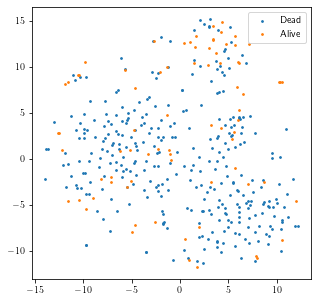

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(X_embedded[index_f,0], X_embedded[index_f,1],label='Dead',s=3)
plt.scatter(X_embedded[index_t,0], X_embedded[index_t,1],label='Alive',s=3)
plt.legend()
plt.show()

In [10]:
# ## remove variables
remove_var = '''"os_months"    "MIR107"      "SNORD115_41" "MIR1272"     "MIR30D"      "PRAMEF36P"   "MIR6737"     "ACTRT2"      "MIR517C"     "LINC02229"
"MIR216A"     "OR2T5"       "USP17L6P"    "OR10A7"      "MIR4307"     "LCE2B"       "MIR646"      "MIR548AQ"    "CFC1B"
"OR6C6"       "MIR934"      "FAM90A10P"   "LINC02291"   "CSN2"        "MAGEA9"      "OR6K2"       "MIR2053"     "OR14A2"
"MIR1264"     "OR4F17"      "TTTY7B"      "OR10G9"      "MIR5591"     "MIR5680"     "MIR1911"     "OR13C3"      "MIR8068"
"MIR3141"     "MIR7853"     "OR5W2"       "LOC649133"   "MIR4533"     "VCY"         "MIR6814"     "MIR7854"     "MBD3L2"
"OR5J2"       "SNORD109B"   "C5orf66_AS2" "OR14K1"      "MIR4675"     "MIR6499"     "DAOA_AS1"    "OR8B2"       "MIR4684"
"MIR188"      "MIR5088"     "LINC00879"   "LINC00411"   "OR8G5"       "LINC02297"   "TRIM49D1"    "GPR119"      "OR10G6"'''
remove_var = remove_var.split('"')[1::2]
len(remove_var)

64

In [11]:
numerical_df = numerical_df.drop(labels=remove_var,axis=1)
numerical_df_test = numerical_df_test.drop(labels=remove_var,axis=1)

In [12]:
array = numerical_df
index_f = np.where(np.asarray(df)[:,4]==False)
index_t = np.where(np.asarray(df)[:,4]==True)
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
X_embedded = tsne.fit_transform(array)

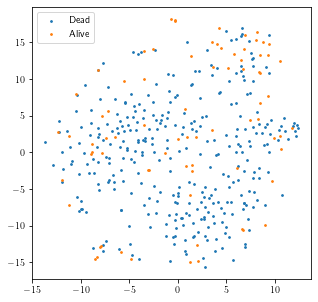

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(X_embedded[index_f,0], X_embedded[index_f,1],label='Dead',s=3)
plt.scatter(X_embedded[index_t,0], X_embedded[index_t,1],label='Alive',s=3)
plt.legend()
plt.show()

In [14]:
# ## Two categories
print(numerical_df.columns[922], numerical_df.columns[923])
# Columns of block 1
columns1 = numerical_df.columns[1:923]
# Columns of block 2
columns2 = numerical_df.columns[923:]

ZNF704 cg06971096


In [15]:
#Create train and test sets
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X = numerical_df
y = df['dead']

X_t1, X_t2, y_t1, y_t2 = train_test_split(X, y, test_size=0.33, random_state=42)

# Net 1 for block 1
clf1 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf1.fit(X_t1[columns1], y_t1)

# Net 2 for block 2
clf2 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf2.fit(X_t1[columns2], y_t1)

# Performance of two nets separately
print(np.sum(y_t1==clf1.predict(X_t1[columns1])), len(X_t1))
print(np.sum(y_t2==clf1.predict(X_t2[columns1])), len(X_t2))


print(np.sum(y_t1==clf2.predict(X_t1[columns2])), len(X_t1))
print(np.sum(y_t2==clf2.predict(X_t2[columns2])), len(X_t2))

# Aggregation of the output of 2 nets + age
agg_y_t1 = np.vstack((X_t1['age'], clf1.predict_proba(X_t1[columns1])[:,0],clf2.predict_proba(X_t1[columns2])[:,0])).T
agg_y_t2 = np.vstack((X_t2['age'], clf1.predict_proba(X_t2[columns1])[:,0],clf2.predict_proba(X_t2[columns2])[:,0])).T


# Final net 3
clf3 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf3.fit(agg_y_t1, y_t1)

print(np.sum(y_t1==clf3.predict(agg_y_t1)), len(X_t1))
print(np.sum(y_t2==clf3.predict(agg_y_t2)), len(X_t2))

# Evaluation on test
X_test = numerical_df_test[columns1]
y_test = clf1.predict(X_test)


270 273
113 135
271 273
99 135
272 273
113 135


In [16]:
print(np.mean(y_t1==clf3.predict(agg_y_t1)), len(X_t1))
print(np.mean(y_t2==clf3.predict(agg_y_t2)), len(X_t2))

0.9963369963369964 273
0.837037037037037 135


In [17]:
string = []
for x in y_test:
    if(x):
        string.append('TRUE')
    else:
        string.append('FALSE')
string = np.asarray(string)

In [18]:
columns2

Index(['cg06971096', 'cg01201932', 'cg11316784', 'cg26091142', 'cg06026548',
       'cg02039634', 'cg13130696', 'cg18464559', 'cg08103551', 'cg09099830',
       ...
       'cg00055848', 'cg17124408', 'cg01751470', 'cg03209541', 'cg17257676',
       'cg09776513', 'cg00417165', 'cg10691006', 'cg26870192', 'cg18317492'],
      dtype='object', length=1000)

In [19]:
with open(r'results.txt', 'w') as f:
    f.write("\n".join(map(str, string)))